Read/Tidy results from PCA-SIFT Training

In [1]:
import pickle
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

In [2]:
TOP_10_CATS_ID = set([1,  3, 62, 84, 44, 47, 67, 51, 10, 31])
CATS_NAMES = {
    1: 'person',
    3: 'car',
    62: 'chair',
    84: 'book',
    44: 'bottle',
    47: 'cup',
    67: 'dinning table',
    51: 'traffic light',
    10: 'bowl',
    31: 'handbag'
}

LABEL_LOGITS_MAPPING = {
    1: 0,
    3: 1,
    62: 2,
    84: 3,
    44: 4,
    47: 5,
    67: 6,
    51: 7,
    10: 8,
    31: 9
}
LOGITS_LABEL_MAPPING = {v:k for k, v in LABEL_LOGITS_MAPPING.items()}
LABELS = [CATS_NAMES[k] for k in LABEL_LOGITS_MAPPING.keys()]

In [3]:
tdy = datetime(2025, 4, 25, 1, 33, 26)
top_model_dir = Path(f'models_coco/PCA-SIFT/{tdy.strftime("%Y%m%d-%H%M%S")}/')

if not top_model_dir.exists():
    raise FileNotFoundError(f"Directory {top_model_dir} does not exist.")

In [4]:
# go through all directories in the top_model_dir to build the hyperparameter grid for us
# assume there are KMeans and PCA N components as hyperparameters

def get_hyperparameter_grid(top_model_dir):
    hyperparameter_grid = []
    for model_dir in top_model_dir.iterdir():
        if not model_dir.is_dir():
            continue
        # get the KMeans n_clusters
        kmeans_n_clusters = int(model_dir.name.split('_')[1])
        # get the PCA N components
        pca_n_components = int(model_dir.name.split('_')[3])
        # add to the hyperparameter grid
        hyperparameter_grid.append((kmeans_n_clusters, pca_n_components))
    return hyperparameter_grid

hyperparameter_grid = sorted(get_hyperparameter_grid(top_model_dir))
hyperparameter_grid

[(20, 20), (20, 50)]

In [5]:
# create a dataframe to store the results
# we are interested in weighted acc of all models in test and evaluation sets
# and weighted F1 score on both sets

df_testset = pd.DataFrame(columns=['kmeans_n_clusters', 'pca_n_components', 'weighted_acc', 'weighted_f1'])
df_evalset = pd.DataFrame(columns=['kmeans_n_clusters', 'pca_n_components', 'weighted_acc', 'weighted_f1'])

In [6]:
# we loop through the hyperparameter grid
# visit the directory
# grab the y_test_ , y_pred_test, y_eval_, y_pred_eval_ numpy array files
# and load them
# then we calculate the weighted acc and f1 score

import numpy as np
from sklearn.metrics import classification_report, balanced_accuracy_score

def calculate_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred, output_dict=True)
    acc = report['accuracy']
    weighted_acc = balanced_accuracy_score(y_true, y_pred)
    weighted_f1 = report['weighted avg']['f1-score']
    return acc, weighted_acc, weighted_f1

for kmeans_n_clusters, pca_n_components in hyperparameter_grid:
    # visit the directory
    model_dir = top_model_dir / f'KMeans_{kmeans_n_clusters}_PCA_{pca_n_components}'
    if not model_dir.exists():
        continue
    # load the y_test_ , y_pred_test, y_eval_, y_pred_eval_ numpy array files
    y_test = np.load(model_dir / f'y_test_filtered_{kmeans_n_clusters}_{pca_n_components}.npy')
    y_pred_test = np.load(model_dir / f'y_pred_test_{kmeans_n_clusters}_{pca_n_components}.npy')
    y_eval = np.load(model_dir / f'y_val_filtered_{kmeans_n_clusters}_{pca_n_components}.npy')
    y_pred_eval = np.load(model_dir / f'y_pred_val_{kmeans_n_clusters}_{pca_n_components}.npy')

    # calculate the metrics
    acc_test, weighted_acc_test, weighted_f1_test = calculate_metrics(y_test, y_pred_test)
    acc_eval, weighted_acc_eval, weighted_f1_eval = calculate_metrics(y_eval, y_pred_eval)

    print('---' * 20)
    print(f'KMeans n_clusters: {kmeans_n_clusters}, PCA n_components: {pca_n_components}')
    print(f'Weighted Acc Test: {weighted_acc_test}, Weighted F1 Test: {weighted_f1_test}')
    print(f'Weighted Acc Eval: {weighted_acc_eval}, Weighted F1 Eval: {weighted_f1_eval}')
    print('---' * 20)
    # add to the dataframe
    df_testset = pd.concat([df_testset, pd.DataFrame({'kmeans_n_clusters': [kmeans_n_clusters],
                                                      'pca_n_components': [pca_n_components],
                                                      'acc': [acc_test],
                                                      'weighted_acc': [weighted_acc_test],
                                                      'weighted_f1': [weighted_f1_test]})], ignore_index=True)

    df_evalset = pd.concat([df_evalset, pd.DataFrame({'kmeans_n_clusters': [kmeans_n_clusters],
                                                      'pca_n_components': [pca_n_components],
                                                      'acc': [acc_eval],
                                                      'weighted_acc': [weighted_acc_eval],
                                                      'weighted_f1': [weighted_f1_eval]})], ignore_index=True)

------------------------------------------------------------
KMeans n_clusters: 20, PCA n_components: 20
Weighted Acc Test: 0.1, Weighted F1 Test: 0.14712524306996397
Weighted Acc Eval: 0.1, Weighted F1 Eval: 0.39718893636465724
------------------------------------------------------------


/root/miniforge3/envs/comp61342_asm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniforge3/envs/comp61342_asm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/miniforge3/envs/comp61342_asm/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

FileNotFoundError: [Errno 2] No such file or directory: 'models_coco/PCA-SIFT/20250425-013326/KMeans_20_PCA_50/y_test_filtered_20_50.npy'

In [7]:
df_testset

,kmeans_n_clusters,pca_n_components,weighted_acc,weighted_f1,acc
0,20,20,0.1,0.147125,0.310488


In [8]:
df_evalset

,kmeans_n_clusters,pca_n_components,weighted_acc,weighted_f1,acc
0,20,20,0.1,0.397189,0.555865


In [9]:
# sort the dataframes by weighted f1 score
df_testset.sort_values(by='weighted_f1', ascending=False)

,kmeans_n_clusters,pca_n_components,weighted_acc,weighted_f1,acc
0,20,20,0.1,0.147125,0.310488


In [10]:
df_evalset.sort_values(by='weighted_f1', ascending=False)

,kmeans_n_clusters,pca_n_components,weighted_acc,weighted_f1,acc
0,20,20,0.1,0.397189,0.555865


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot the results as multi-line plots

def plot_results(df, title):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x='kmeans_n_clusters', y='weighted_f1', hue='pca_n_components', marker='o')
    plt.title(title)
    plt.xlabel('KMeans n_clusters')
    plt.ylabel('Weighted F1 Score')
    plt.legend(title='PCA n_components')
    plt.grid()
    plt.show()

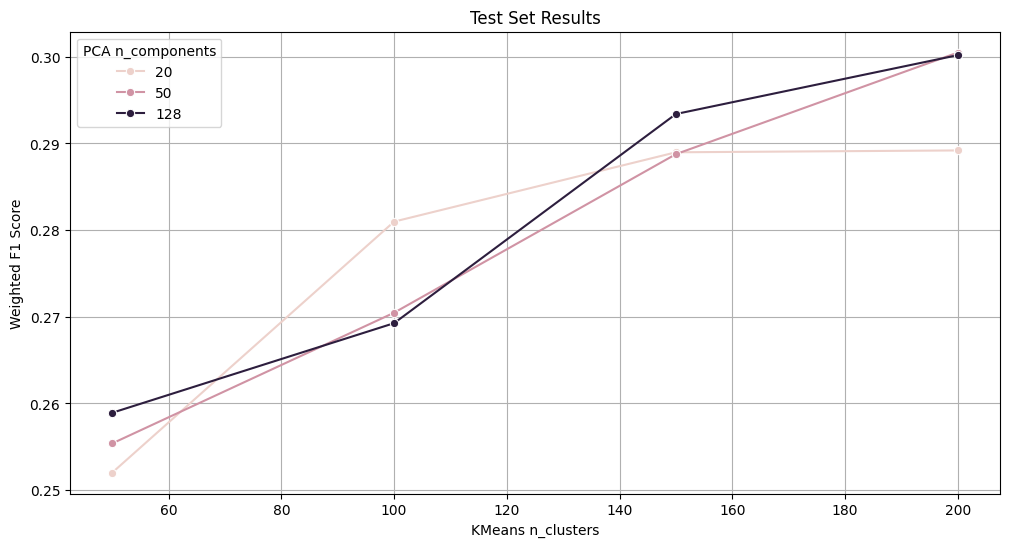

In [16]:
plot_results(df_testset, 'Test Set Results')

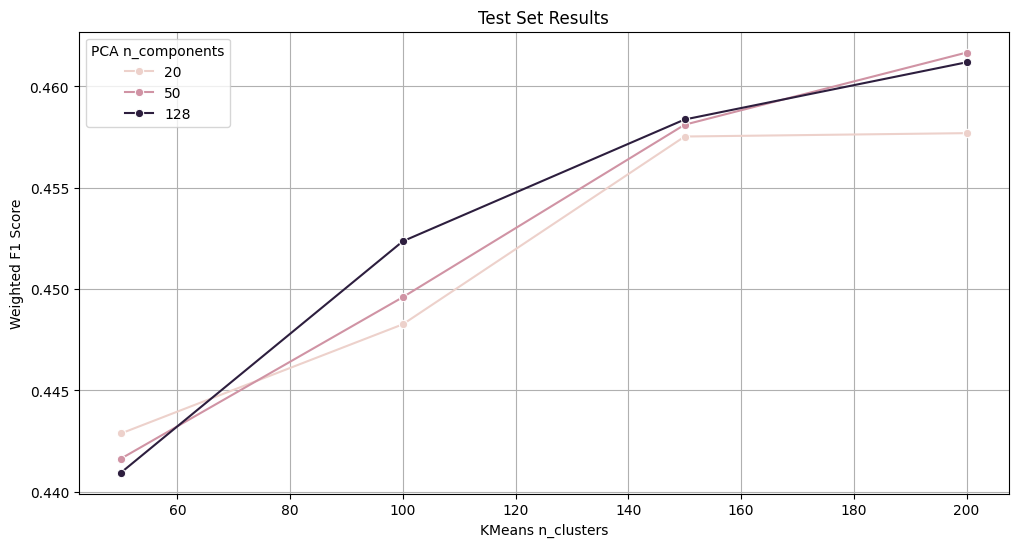

In [17]:
plot_results(df_evalset, 'Test Set Results')

Select the best model and view its confusion matrix

In [56]:
from sklearn.metrics import ConfusionMatrixDisplay

best_model_eval = df_evalset.loc[df_evalset['weighted_f1'].idxmax()]
best_kmeans_n_clusters, best_pca_n_components = best_model_eval['kmeans_n_clusters'], best_model_eval['pca_n_components']

model_dir = top_model_dir / f'KMeans_{best_kmeans_n_clusters}_PCA_{best_pca_n_components}'
if not model_dir.exists():
    raise FileNotFoundError(f"Directory {model_dir} does not exist.")

# load the y_test_ , y_pred_test, y_eval_, y_pred_eval_ numpy array files
y_test = np.load(model_dir / f'y_test_filtered_{best_kmeans_n_clusters}_{best_pca_n_components}.npy')
y_pred_test = np.load(model_dir / f'y_pred_test_{best_kmeans_n_clusters}_{best_pca_n_components}.npy')
y_eval = np.load(model_dir / f'y_val_filtered_{best_kmeans_n_clusters}_{best_pca_n_components}.npy')
y_pred_eval = np.load(model_dir / f'y_pred_val_{best_kmeans_n_clusters}_{best_pca_n_components}.npy')

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8), dpi=300)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=LABELS, yticklabels=LABELS)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.xticks(rotation=90)
    plt.ylabel('True')
    plt.show()

    # cm = confusion_matrix(y_true, y_pred)
    # cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    # fig, ax = plt.subplots(figsize=(10, 10), dpi=300)
    # cm_disp.plot(ax=ax, cmap='Blues', values_format='d', xticks_rotation=90)

    # Assuming you have a list of class names

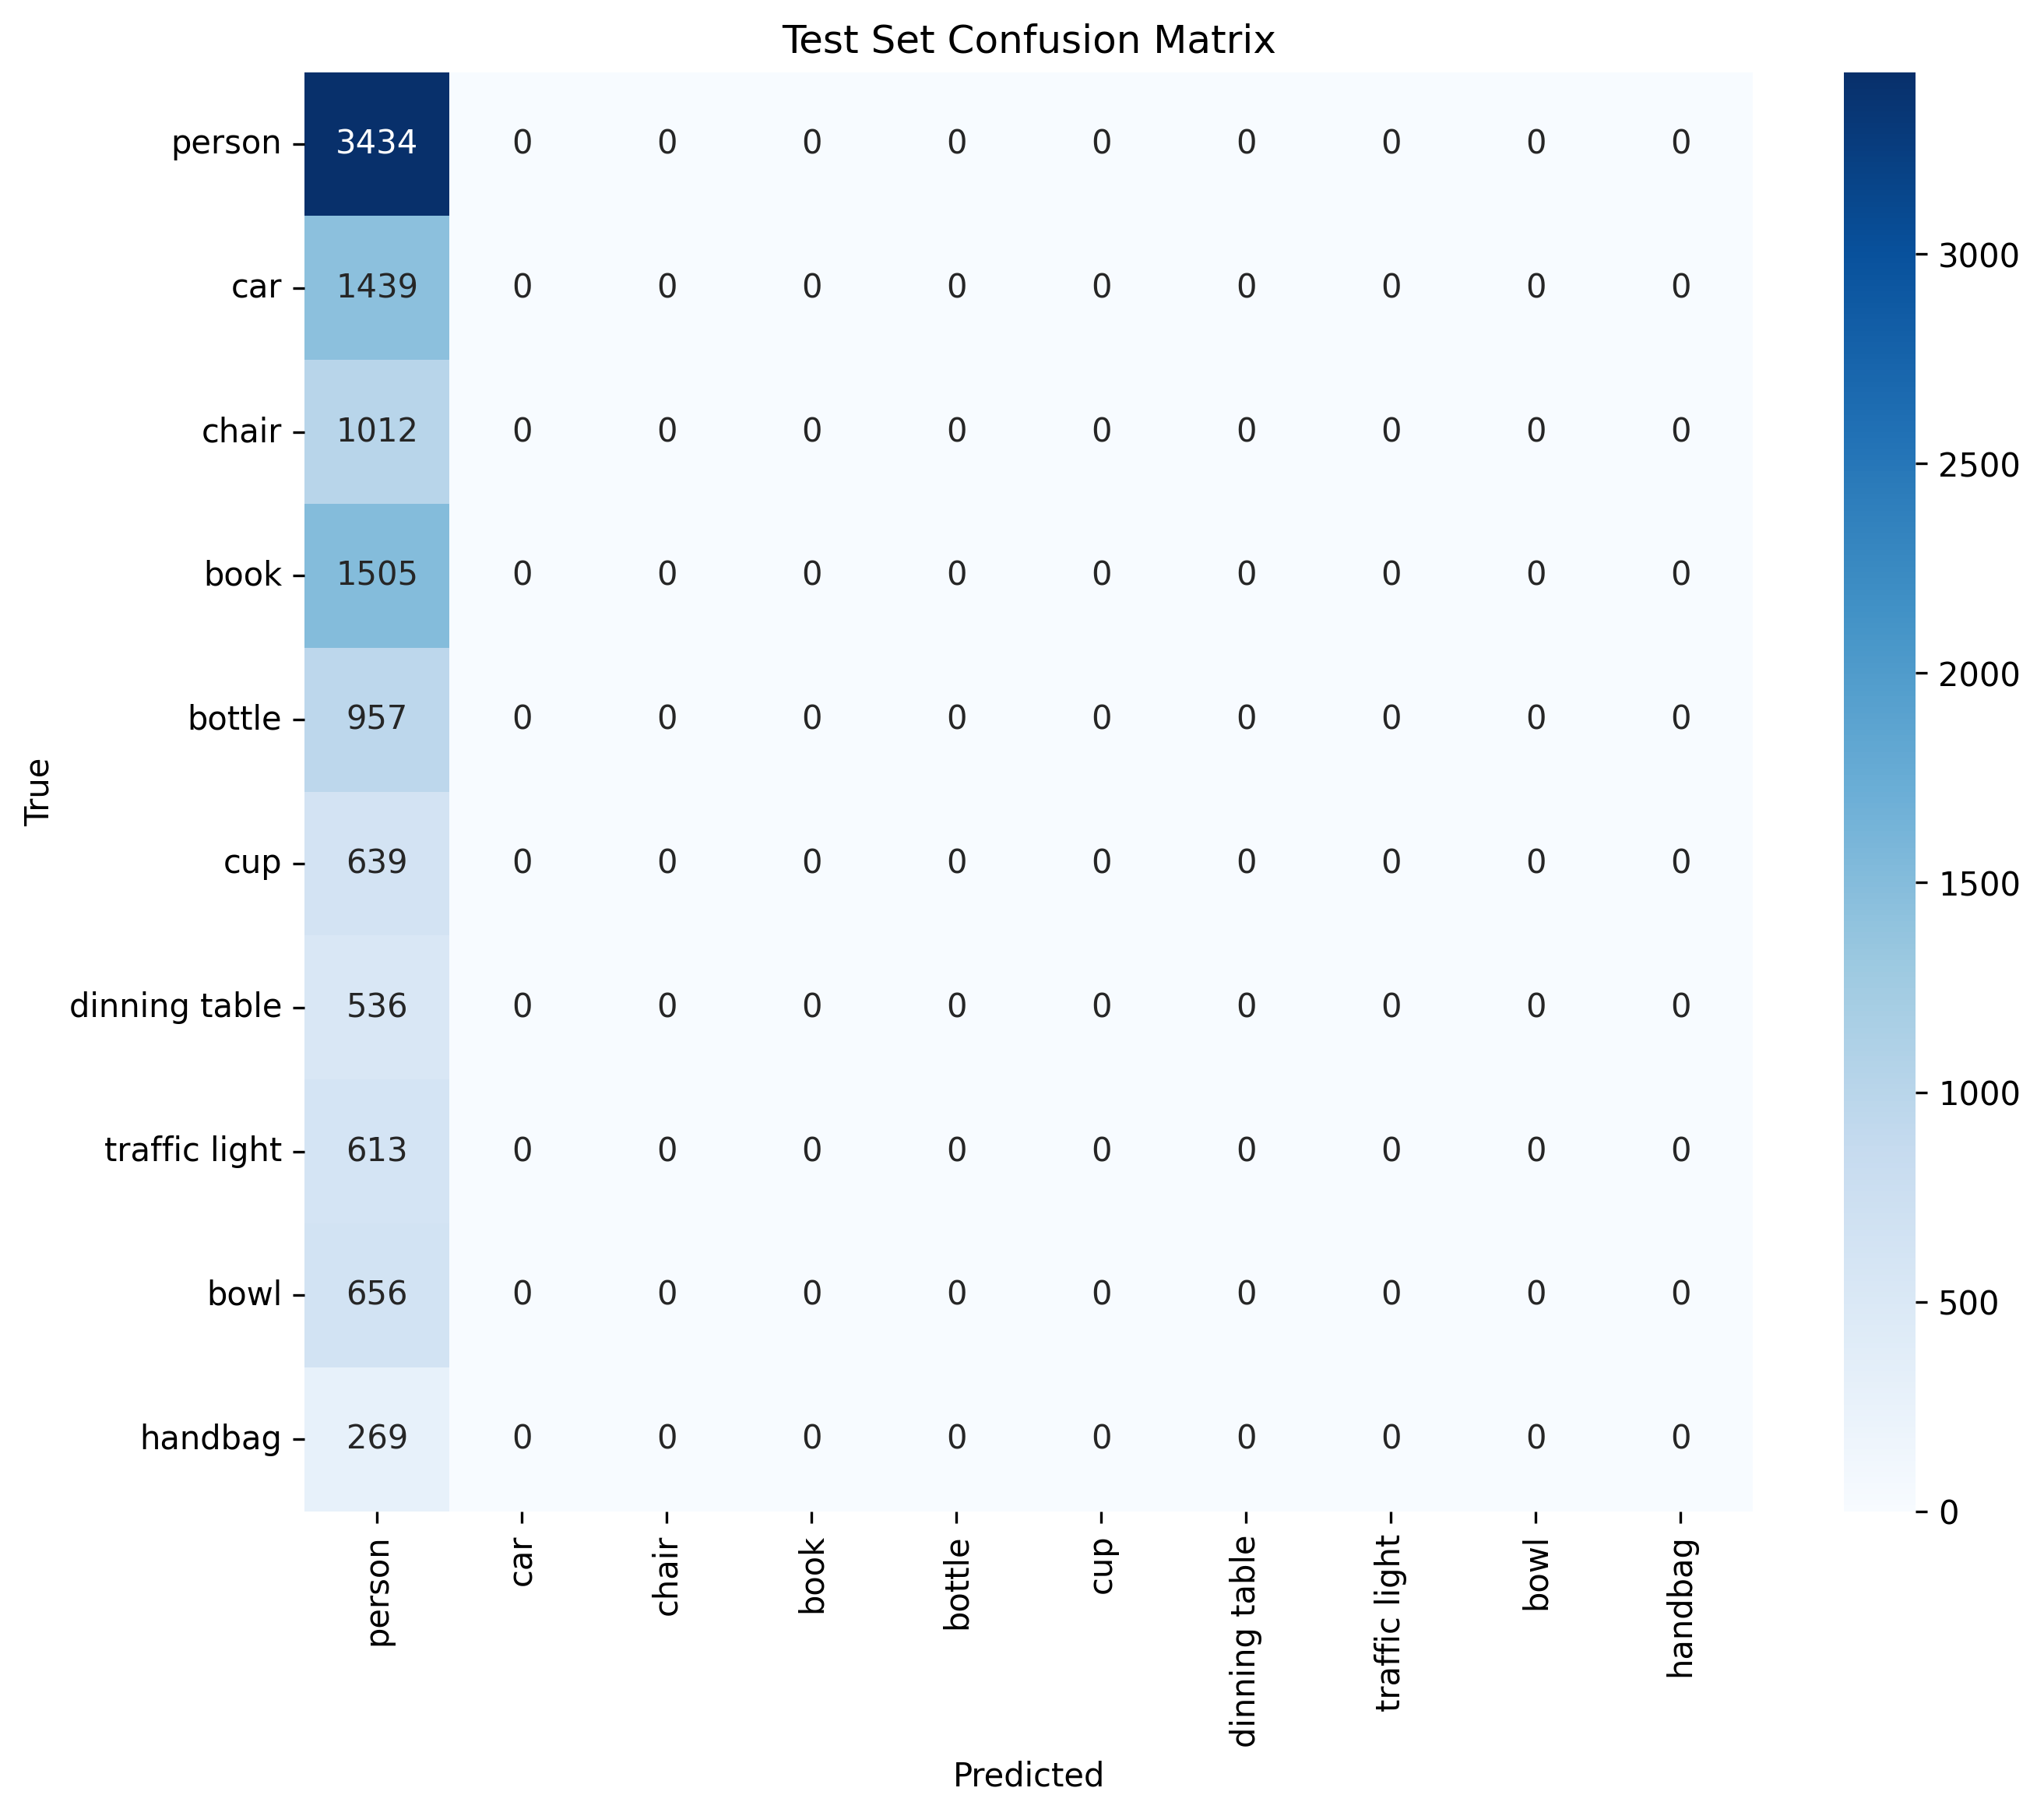

In [57]:
plot_confusion_matrix(y_test, y_pred_test, LABELS, 'Test Set Confusion Matrix')

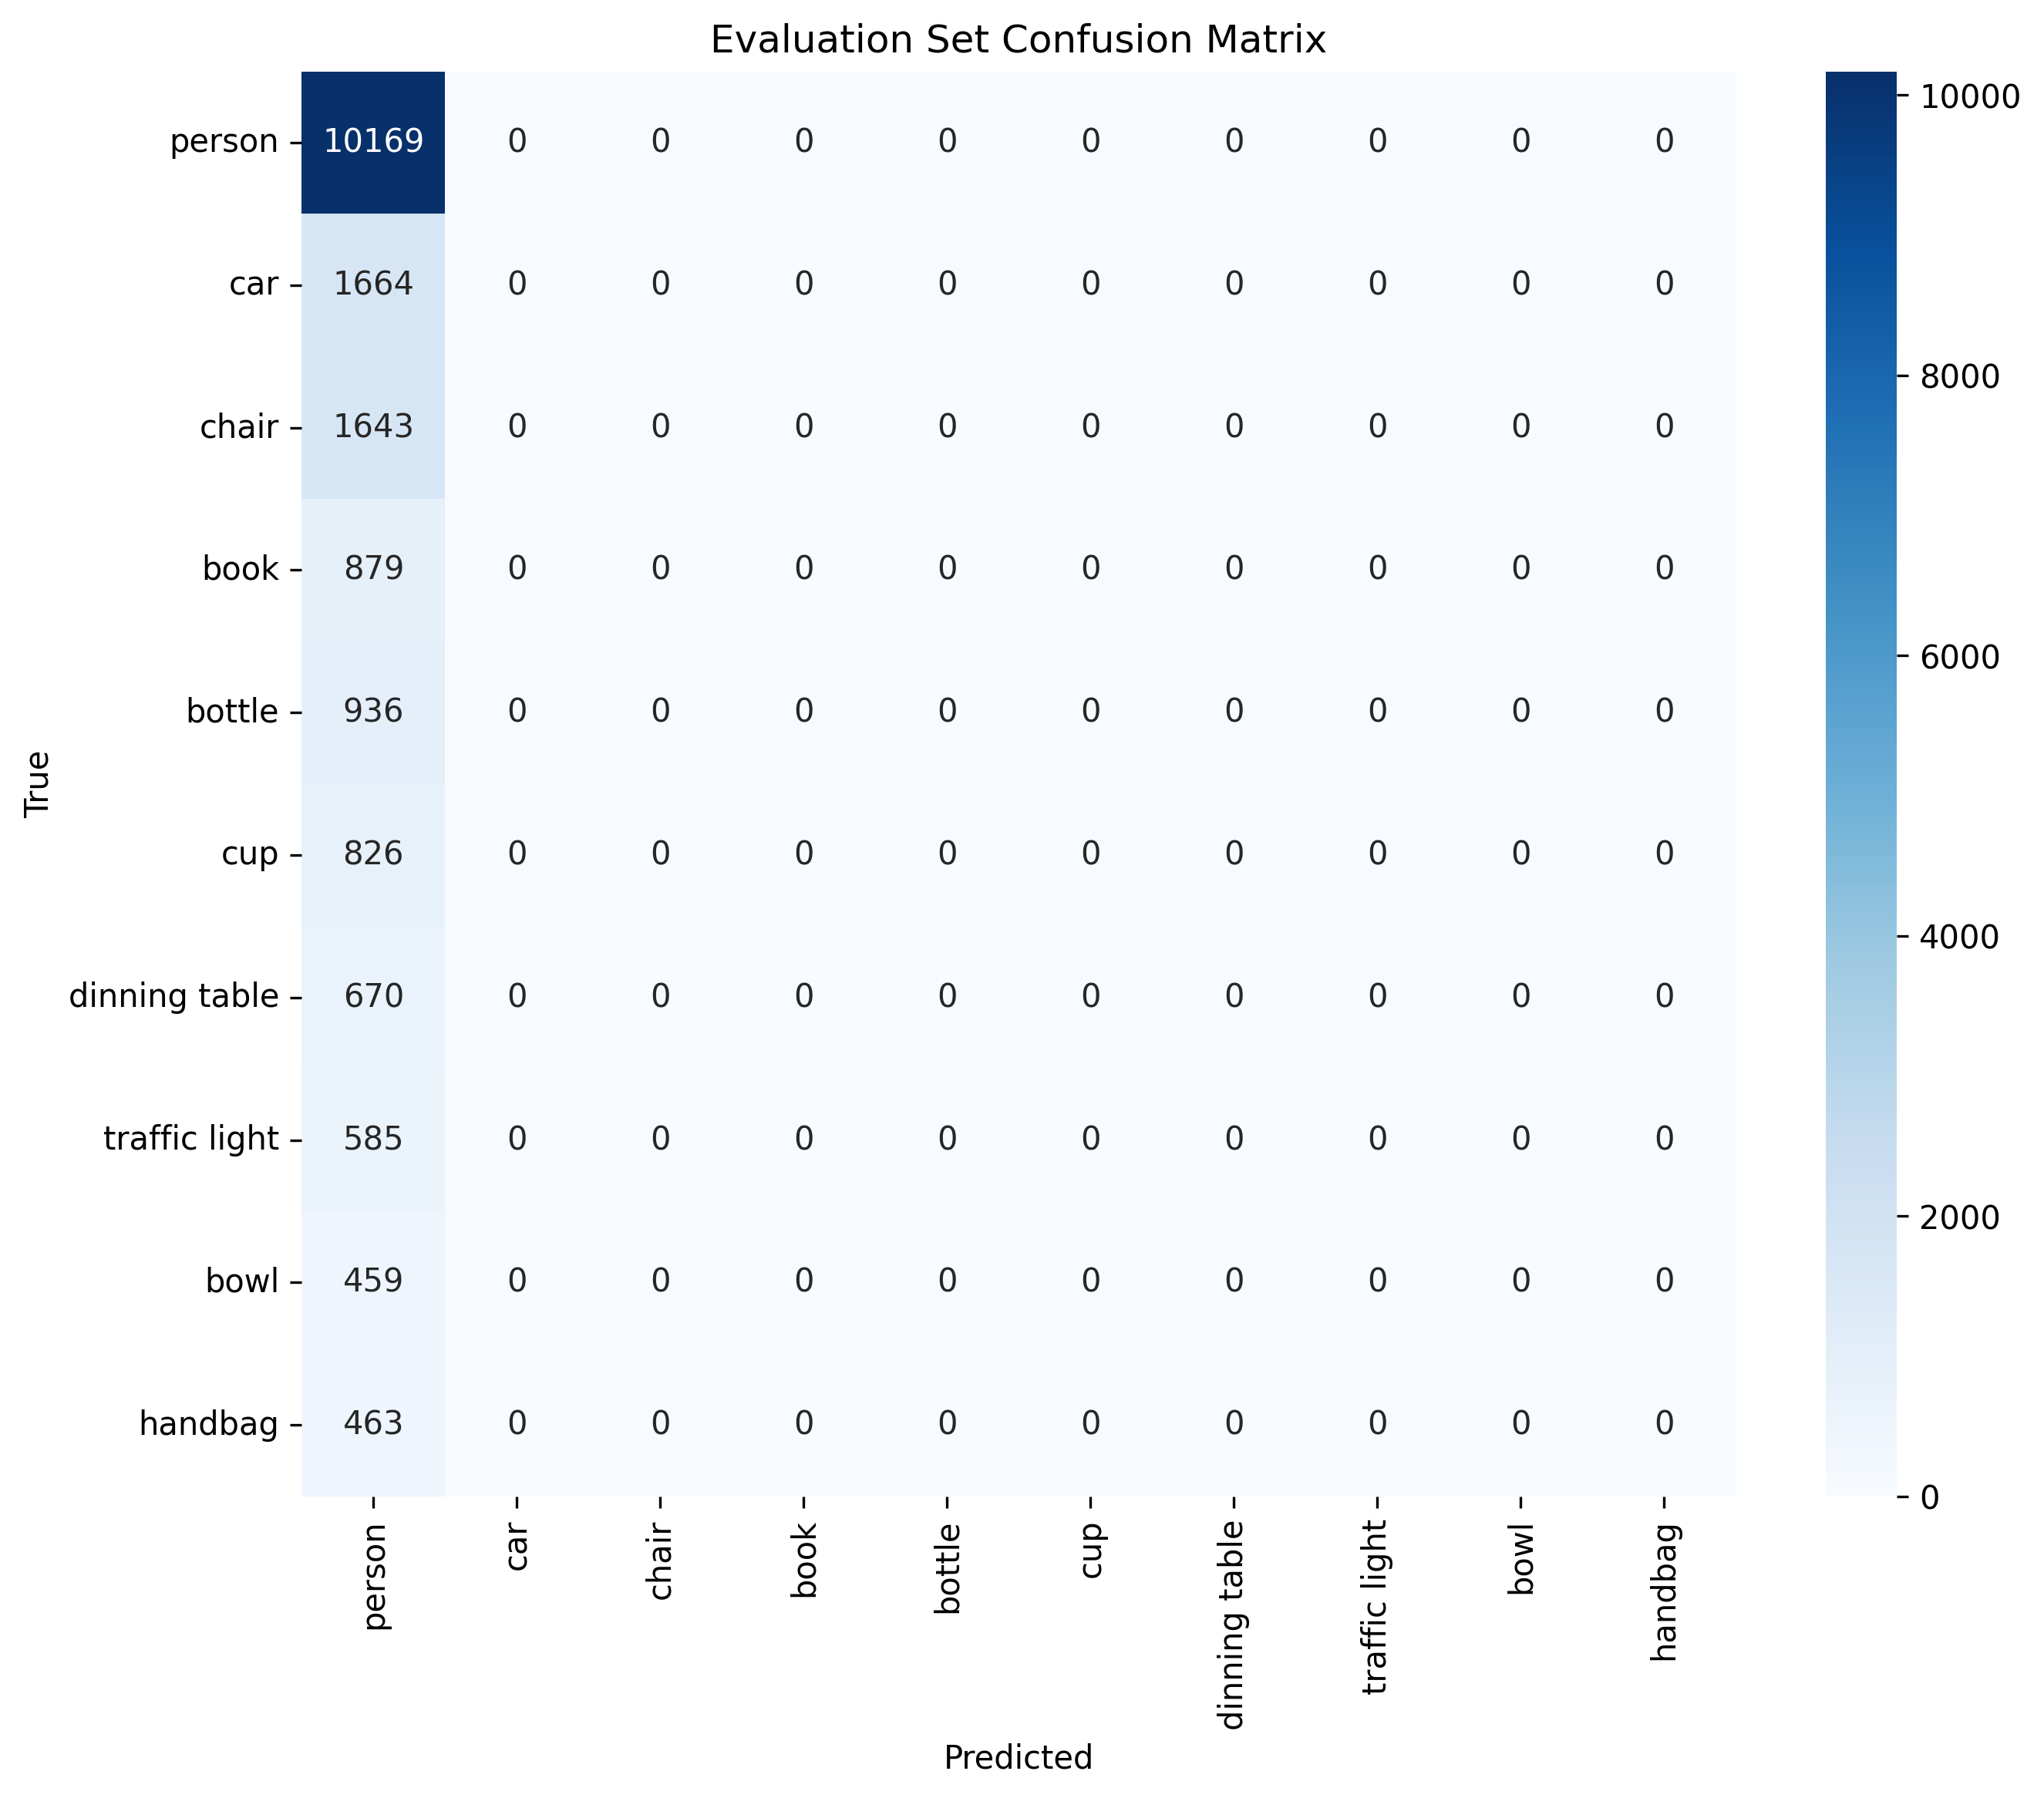

In [58]:
plot_confusion_matrix(y_eval, y_pred_eval, LABELS, 'Evaluation Set Confusion Matrix')

In [15]:
y_eval

array([4, 6, 0, ..., 5, 0, 0], dtype=int32)

In [16]:
y_pred_eval

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)